In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [164]:
import imp
import rp_experiments
import gp_helpers
import pandas as pd
import matplotlib.pyplot as plt
imp.reload(rp_experiments)
imp.reload(gp_helpers)

<module 'gp_helpers' from '/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py'>

# 1. Description of the experiments run

Define the random projection kernel as follows:

$k_{RP}(x_1, x_2) = \sum_{j=1}^J \frac{1}{J}\exp(-\frac{1}{2 l_j^2} ||P^{(j)} x_1 - P^{(j)} x_2||_2^2),$

where each $P^{(j)}$ is a $k \times d$ random projection matrix with elements sampled from $\frac{1}{\sqrt{k}}N(0,1)$. Hyerparameters of the kernel are the number of projections $J$, the size of projections $k$, and length scales $l_1, ..., l_{J}$.

In all of the following experiments, each Gaussian process's hyperparameters (which are lengthscales, Gaussian observation noise variance, and kernel scale) were fitted through minimization of the negative log marginal likelihood. The optimization was performed using ADAM with learning rate 0.1, training until convergence, which is determined when the moving average of the loss decreases by less than 1e-4 after 20 epochs.

Each dataset is normalized as a whole (instead of just using training data) with 0 mean and unit variance for all features and target variables.

The first experiment shown below tracks the test log likelihood and mean squared error of Gaussian processes with random projection kernels as k and J are varied. These metrics are also compared with the RBF kernel. For each regreession dataset in the UCI repository up to at most 2565 data points, a total of 22 models are compared: a single RBF GP and the RP GP with k=1, k=4, or k=10 and J=1,2,3,5,8,13,20. For each model, 10-fold cross-validation is performed twice in order to obtain good estimates of average performance. Plots show the median and interquartile range of NLL or MSE at each point.

In the second experiment below, the k and J were fixed to 1 and 20 respectively, and the weights of the projection matrices were trained along with GP hyperparameters using the same training procedure on the same datasets with 2 10-fold cross-validations. Box and whisker plots are shown to summarize the performance of such a GP compared to RP kernel with k=1 & J=20, RP kernel with k=4 & J=20, and an RBF kernel.

Note that, to stabilize training, 
* LBFGS is replaced by ADAM. It empirically caused faster, more frequent convergence to a bad optimum where noise collapses. Also, Alex noted that Adam may be better since the gradients are computed with CG and are therefore a little noisy, and that anecdotally the Pytorch implementation isn't very good.
* CG tolerance is decreased from 0.05 to 0.01 for extra precaution. Using no Cholesky solves didn't fix things, and CG worked well after switching to ADAM.
* A liberal box prior is set over observation noise to enforce soft constraints that noise >1e-4 and <10.

In [134]:
def make_plot(k, dataset, robust=True, color='green', plot_bl=True, show_range=True, ds=None, 
              metric='test_nll', label=None):
    ex = ds[ds['dataset'] == dataset].iloc[0]
    dset = ds[ds['dataset'] == dataset]

    n = ex['n']
    d = ex['d']
    values = dset[~dset['RP']][metric].dropna()
    if not robust:
        bl_middle = values.mean()
        bl_below = bl_middle - 2*values.std()
        bl_above = bl_middle + 2*values.std()

        middle_line = dset[dset['RP'] & (dset['k'] == k)].groupby('J')[metric].mean()
        below_line = middle_line - 2*dset[dset['RP'] & (dset['k'] == k)].groupby('J')[metric].std()
        above_line = middle_line + 2*dset[dset['RP'] & (dset['k'] == k)].groupby('J')[metric].std()
    else:
        middle_line = dset[dset['RP'] & (dset['k'] == k)].groupby('J')[metric].median()
        below_line = dset[dset['RP'] & (dset['k'] == k)].groupby('J')[metric].quantile(0.25)
        above_line = dset[dset['RP'] & (dset['k'] == k)].groupby('J')[metric].quantile(0.75)
    
    if plot_bl:
        try:
            bl_middle = np.median(values)
            bl_below = np.percentile(values, 25)
            bl_above = np.percentile(values, 75)
        except Exception:
            print(k, dataset)
            raise
        plt.axhline(bl_middle, color='blue', label='SE')
        plt.fill_between([0, 20], bl_below, bl_above, color='blue', alpha=0.2)
    
    if label is None:
        label = 'RP+SE,k={}'.format(k)
    plt.plot(middle_line.index, middle_line.values, color=color, marker='o', label=label)
    if show_range:
        plt.fill_between(below_line.index, below_line.values, above_line.values, color=color, alpha=0.2)
    plt.title(dataset + ' (n={}, d={})'.format(n, d))
    plt.xlabel("J")
    plt.ylabel(metric)

# 2. Plots of Sensitivity Study on k, J

In [176]:
df = pd.read_csv('./3-24-rp-ablation.csv') 

In [136]:
df.loc[df['RP']==False, ['k', 'J']] = 0

## 2.1 NLL

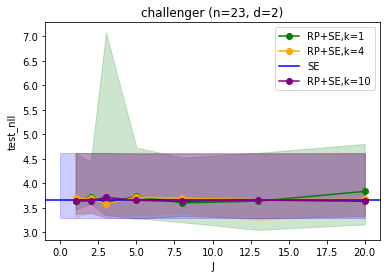

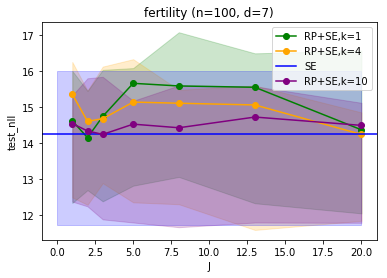

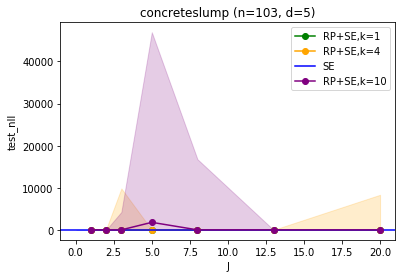

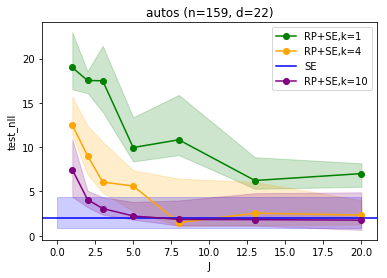

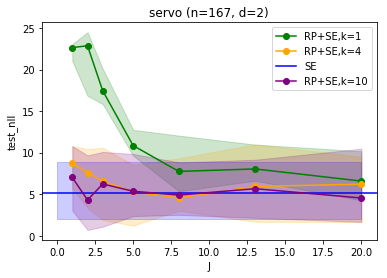

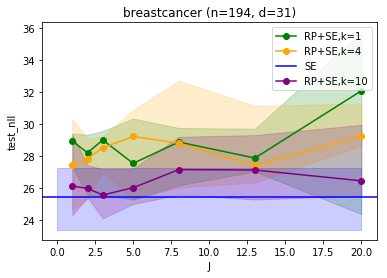

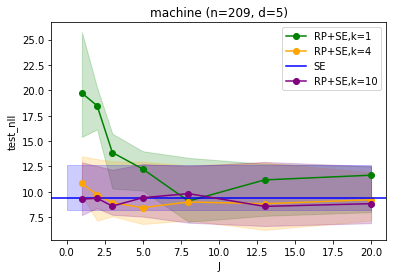

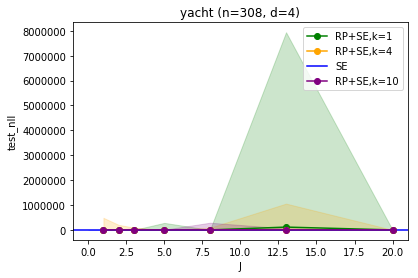

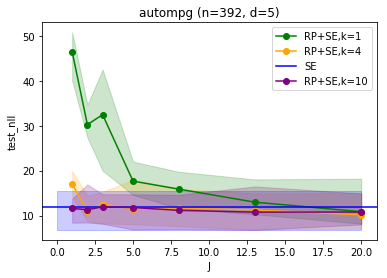

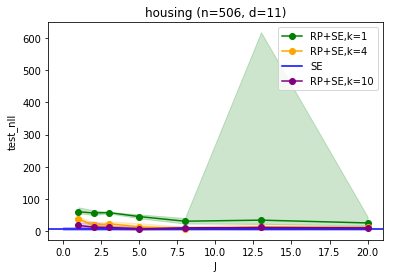

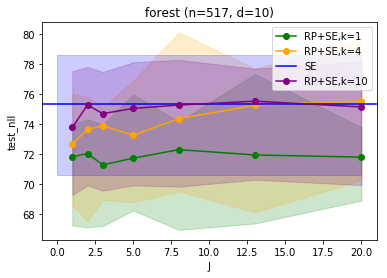

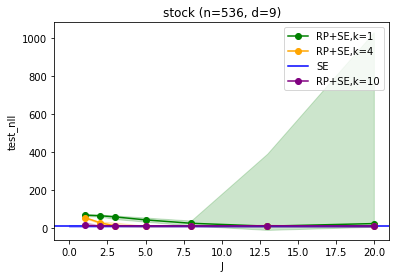

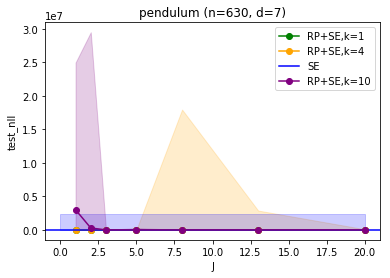

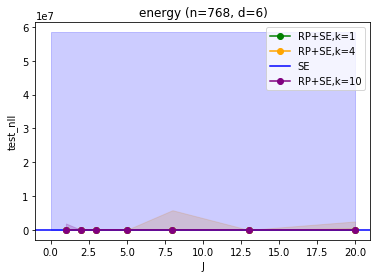

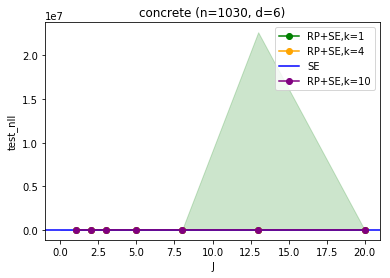

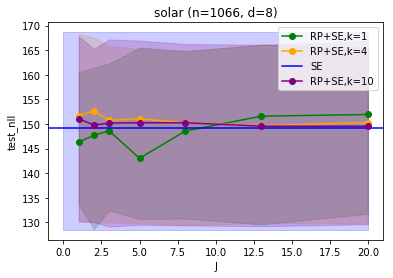

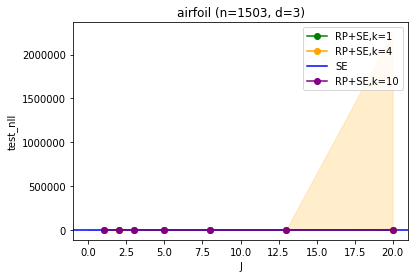

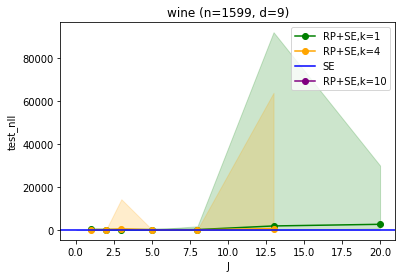

In [137]:
maxlim_list = {}
for dataset in df[df['RP'] == True]['dataset'].unique():
    plt.figure()
    make_plot(1, dataset, show_range=True,  ds=df, plot_bl=False, robust=True, metric='test_nll')
    make_plot(4, dataset, show_range=True,  ds=df, plot_bl=False, color='orange', robust=True, metric='test_nll')
    if dataset == 'gas':
        make_plot(10, dataset, show_range=True,  ds=df, plot_bl=False, color='purple', robust=True, metric='test_nll')
    else:
        make_plot(10, dataset, show_range=True,  ds=df, plot_bl=True, color='purple', robust=True, metric='test_nll')
    if dataset in maxlim_list.keys():
        plt.ylim(maxlim_list[dataset])
    plt.legend()
    plt.savefig('./plots/ablation/nll/{}.png'.format(dataset))
    plt.show()

## 2.2 MSE

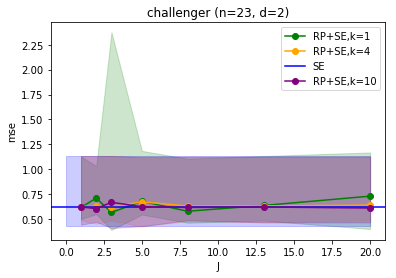

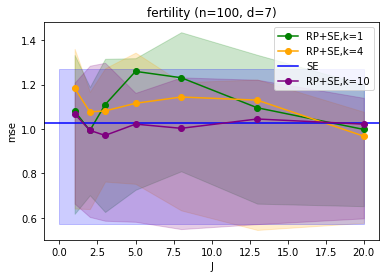

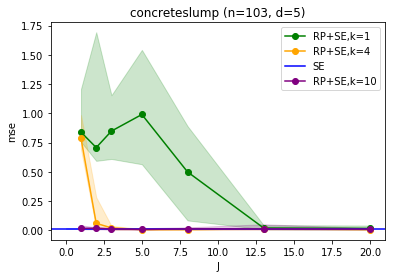

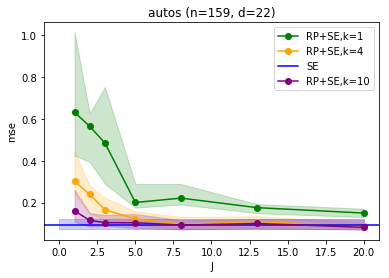

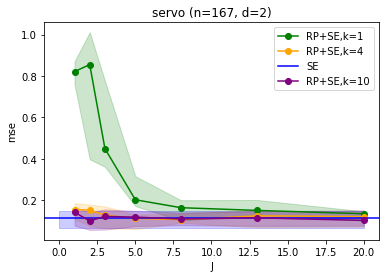

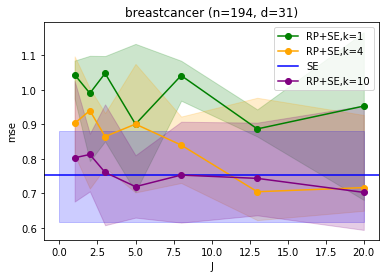

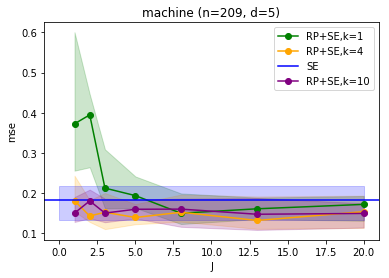

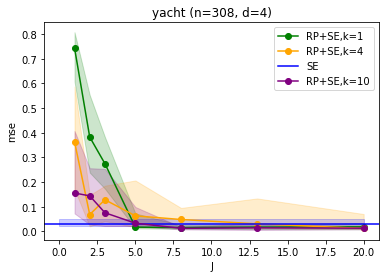

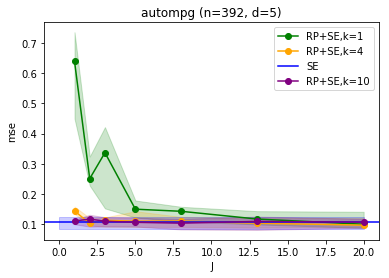

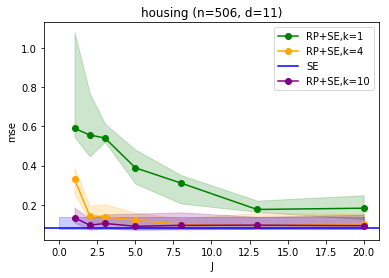

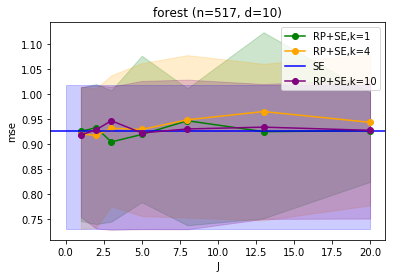

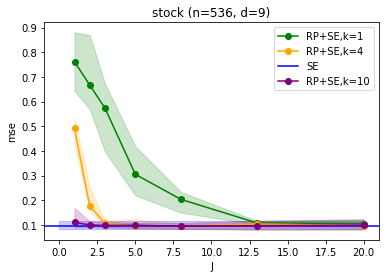

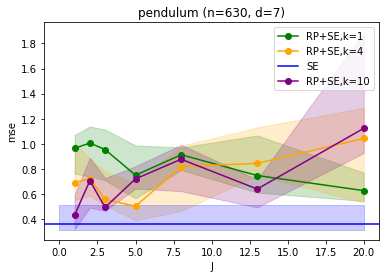

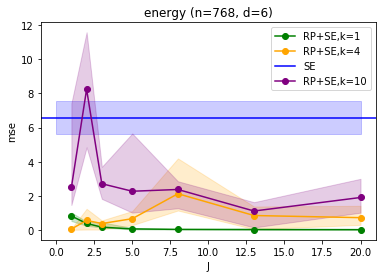

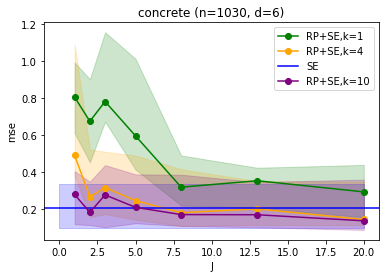

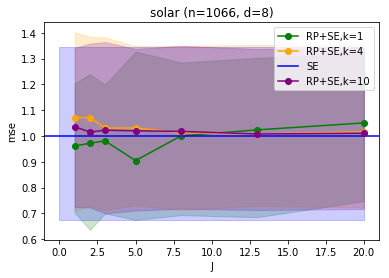

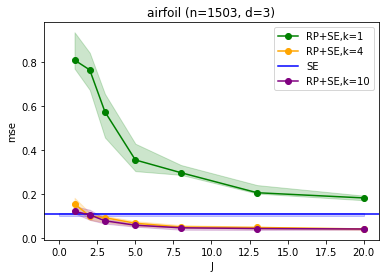

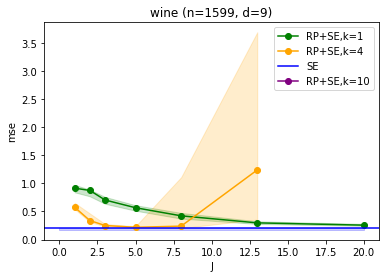

In [138]:
maxlim_list = {
    'gas': (0, 0.2)
}
for dataset in df[df['RP'] == True]['dataset'].unique():
    plt.figure()
    make_plot(1, dataset, show_range=True,  ds=df, plot_bl=False, robust=True, metric='mse')
    make_plot(4, dataset, show_range=True,  ds=df, plot_bl=False, color='orange', robust=True, metric='mse')
    if dataset == 'gas':
        make_plot(10, dataset, show_range=True,  ds=df, plot_bl=False, color='purple', robust=True, metric='mse')
    else:
        make_plot(10, dataset, show_range=True,  ds=df, plot_bl=True, color='purple', robust=True, metric='mse')   
    
#     if dataset in maxlim_list.keys():
#         plt.ylim(maxlim_list[dataset])
#     else:
#         plt.ylim(0,1.2)
    plt.legend()
    plt.savefig('./plots/ablation/mse/{}.png'.format(dataset))
    plt.show()

## 2.3 Table of MSE at k=1

In [160]:
df['group'] = None
df.loc[(df['k']==1) & (df['J']==1), 'group'] = 'RP,k=1,J=1'
df.loc[(df['k']==1) & (df['J']==8), 'group'] = 'RP,k=1,J=8'
df.loc[(df['k']==1) & (df['J']==20), 'group'] = 'RP,k=1,J=20'
df.loc[df['RP'] == False, 'group'] = 'SE'
medians = df.groupby(('dataset', 'group'))['n', 'd', 'mse', 'train_time'].median().unstack()
medians['n'] = medians[('n','SE')]
medians['dn'] = medians[('n', 'SE')]
medians['dd'] = medians[('d', 'SE')]
medians = medians.drop(['n', 'd'], axis=1)
medians = medians.rename(columns={'dn': 'n', 'dd': 'd'})
medians = medians.sort_values(['n', 'd'])
medians = pd.concat([medians[['n', 'd']], medians[['mse', 'train_time']]], axis=1) 

/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  


In [161]:
medians

n   d        mse                                   \
group                   RP,k=1,J=1 RP,k=1,J=20 RP,k=1,J=8        SE   
dataset                                                               
challenger       23   2   0.615710    0.728865   0.577362  0.622800   
fertility       100   7   1.080398    0.997907   1.230857  1.025942   
concreteslump   103   5   0.838447    0.015802   0.498789  0.009603   
autos           159  22   0.631563    0.149711   0.221111  0.092009   
servo           167   2   0.821222    0.135283   0.164523  0.114461   
breastcancer    194  31   1.044156    0.953180   1.041648  0.752847   
machine         209   5   0.372316    0.171840   0.149789  0.182089   
yacht           308   4   0.744336    0.018244   0.015331  0.031343   
autompg         392   5   0.640148    0.098573   0.141691  0.106213   
housing         506  11   0.589958    0.182600   0.310603  0.082261   
forest          517  10   0.924943    0.926430   0.946434  0.926635   
stock           536   9   0.761263    0.105874   0.203690  0.096285   
pendulum        630   7   0.963834    0.626314   0.912494  0.360054   
energy          768   6   0.840852    0.045761   0.061359  6.557221   
concrete       1030   6   0.805985    0.294872   0.320348  0.205453   
solar          1066   8   0.961039    1.050369   1.000335  0.999063   
airfoil        1503   3   0.810648    0.183308   0.297999  0.111387   
wine           1599   9   0.914049    0.255638   0.421481  0.196087   

              train_time                                     
group         RP,k=1,J=1 RP,k=1,J=20  RP,k=1,J=8         SE  
dataset                                                      
challenger      1.758270    5.826458    3.487115   1.422719  
fertility       2.905459    7.246267    5.212044   1.874608  
concreteslump   2.207533   33.397947    5.757100   4.173441  
autos           5.688388   20.039573    9.984133   4.229081  
servo           2.608237   15.005917    7.128846   2.860706  
breastcancer    3.802535   13.107216    8.895395   2.997279  
machine         3.107941   15.207477    9.205368   3.305670  
yacht           3.219995   30.746035   14.046823   4.145083  
autompg         3.656567   24.148536   14.266962   3.626286  
housing         4.447593   35.452290   16.225644   5.390032  
forest          7.197962   50.428119   21.751428   3.879184  
stock           8.155972   74.161361   32.313176   8.187803  
pendulum        4.640092   44.614006   20.690780   8.202800  
energy          6.371819   72.766087   30.330880  10.832494  
concrete        8.641957   98.161831   58.029090  14.521046  
solar          16.030670  115.827371   50.283722   5.914825  
airfoil        15.690789  213.284086   75.600429  23.056983  
wine           14.687420  360.369997  106.040167  23.211475

In [162]:
medians.to_csv('./small-med-medians.csv')

# 3. Performance under modifications

## 3.1 Performance comparison with projection kernel with learned projection matrices

In [139]:
df_lw = pd.read_csv("./learning_weights_results.csv")

In [140]:
df['learn_proj'] = False
df_lw['J'] = 20
df_lw = pd.concat([df_lw, df])

/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [141]:
dsets = rp_experiments.get_small_datasets() + rp_experiments.get_medium_datasets()[:4]

In [142]:
df_lw['group'] = None
df_lw.loc[df_lw['RP']==False, 'group'] = 'SE'
df_lw.loc[(df_lw['RP']==True) & (df_lw['learn_proj'] == False) & (df_lw['k']==1) & (df_lw['J'] == 20), 'group'] = 'RP,k=1,J=20'
df_lw.loc[(df_lw['RP']==True) & (df_lw['learn_proj'] == False) & (df_lw['k']==4) & (df_lw['J'] == 20), 'group'] = 'RP,k=4,J=20'
df_lw.loc[(df_lw['learn_proj'] == True) & (df_lw['k']==1) & (df_lw['J'] == 20), 'group'] = 'LearnProj,k=1,J=20'

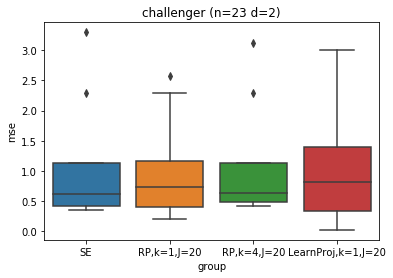

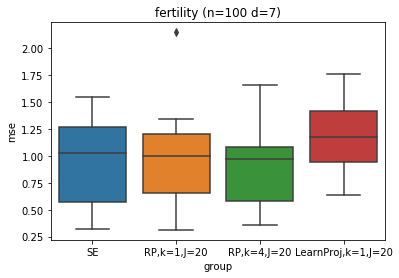

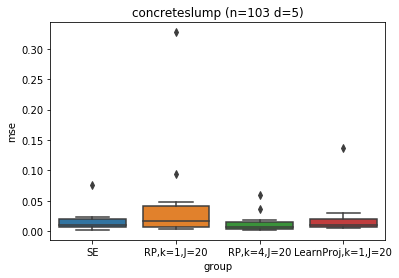

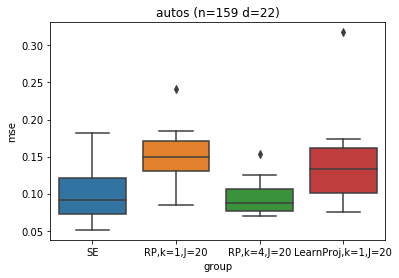

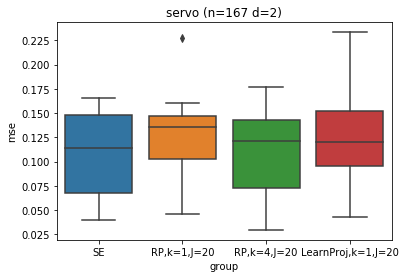

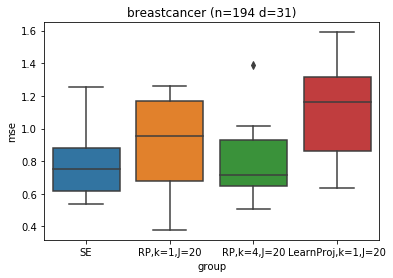

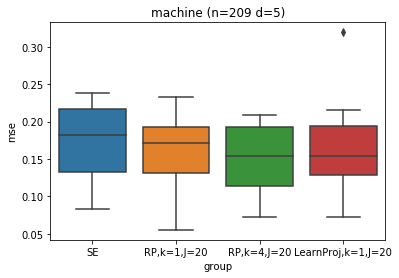

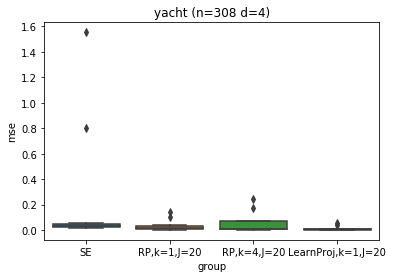

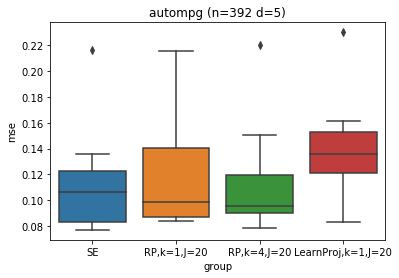

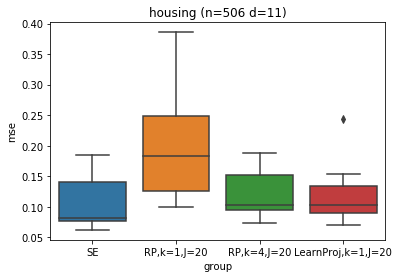

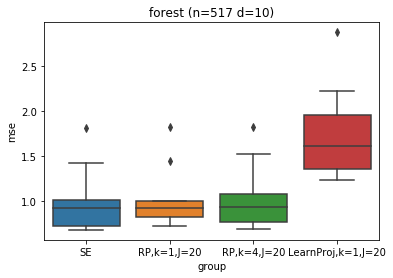

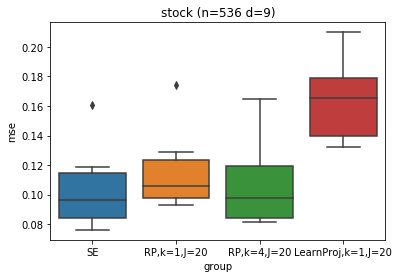

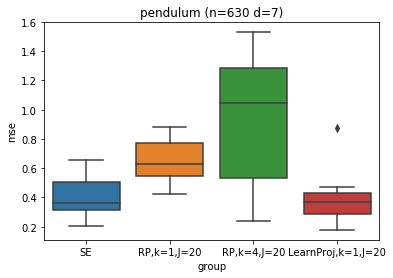

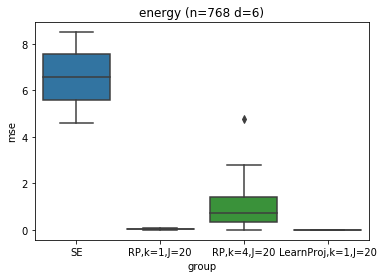

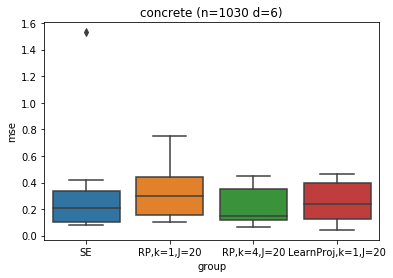

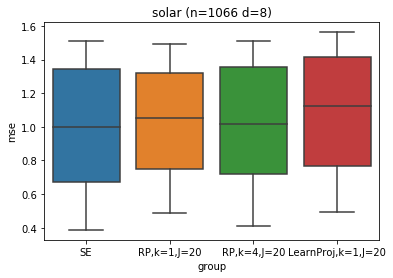

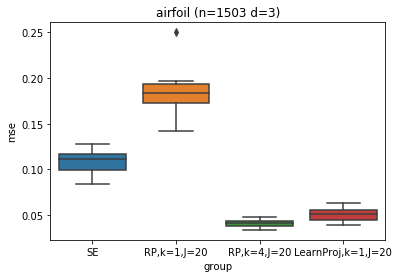

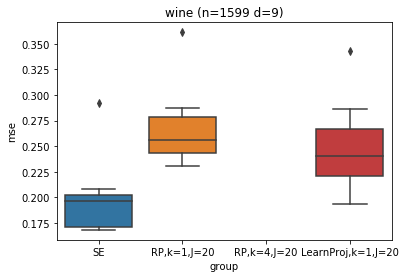

In [143]:
for dset in dsets:
    plt.figure()
    subset = df_lw[df_lw['dataset'] == dset]
    n = subset['n'].iloc[0]
    d = subset['d'].iloc[0]
    sns.boxplot(x='group', y='mse', data=subset, order=['SE', 'RP,k=1,J=20', 'RP,k=4,J=20', 'LearnProj,k=1,J=20'])
    plt.title('{} (n={} d={})'.format(dset, n, d))
    plt.savefig('./plots/learn_proj/{}.png'.format(dataset))
    plt.show()

## 3.2 Performance when allowing linear combo of sub-kernels (instead of average)

In [144]:
df_lw = pd.read_csv("./weighted_kernel_comb_results.csv")

In [145]:
df['weighted_comb'] = False
df_lw['J'] = 20
df_lw = pd.concat([df_lw, df])

/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [146]:
dsets = rp_experiments.get_small_datasets() + rp_experiments.get_medium_datasets()[:4]

In [147]:
df_lw['group'] = None
df_lw.loc[df_lw['RP']==False, 'group'] = 'SE'
df_lw.loc[(df_lw['RP']==True) & (df_lw['weighted_comb'] == False) & (df_lw['k']==1) & (df_lw['J'] == 20), 'group'] = 'RP,k=1,J=20'
df_lw.loc[(df_lw['RP']==True) & (df_lw['weighted_comb'] == False) & (df_lw['k']==4) & (df_lw['J'] == 20), 'group'] = 'RP,k=4,J=20'
df_lw.loc[(df_lw['weighted_comb'] == True) & (df_lw['k']==1) & (df_lw['J'] == 20), 'group'] = 'WeightedKernels,k=1,J=20'

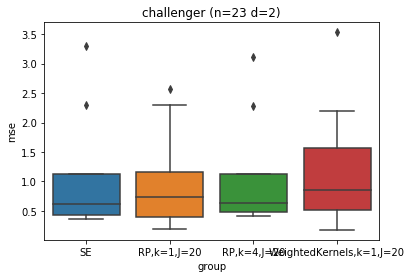

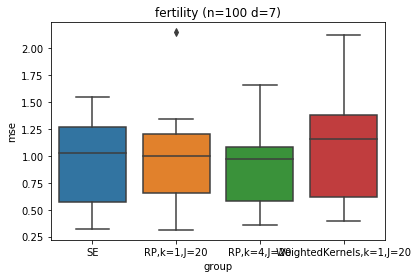

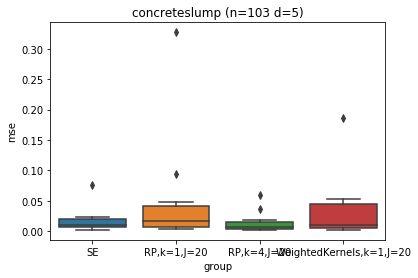

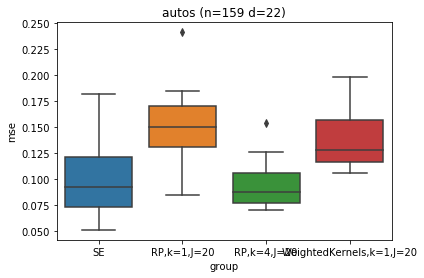

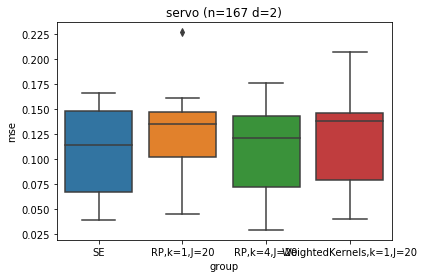

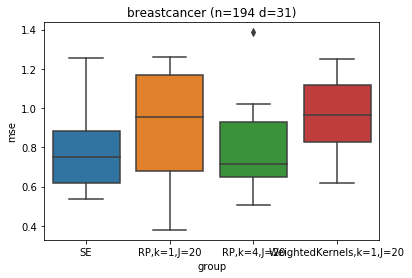

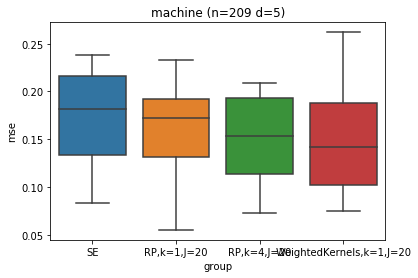

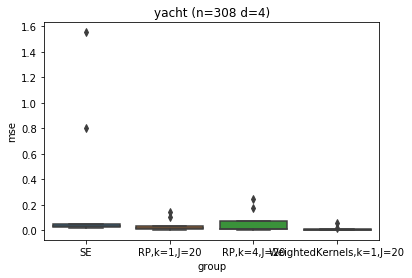

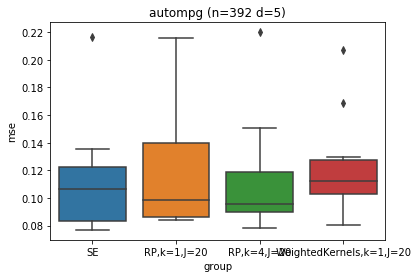

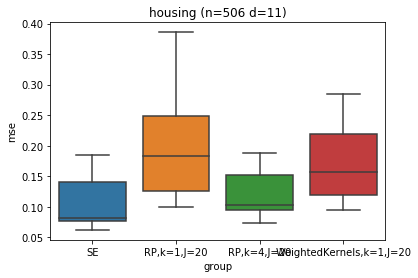

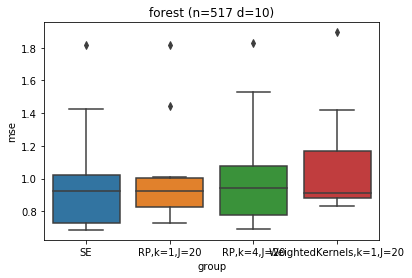

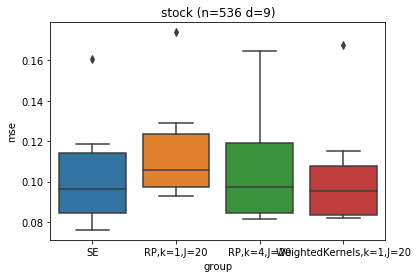

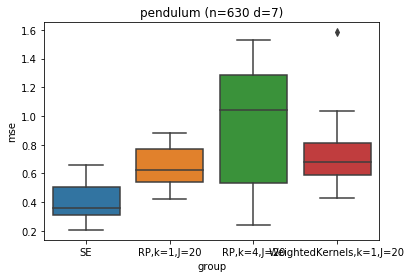

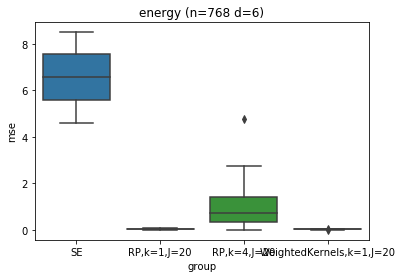

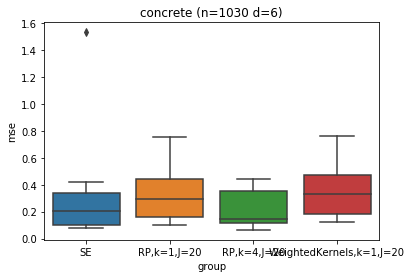

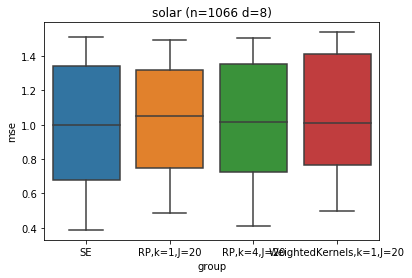

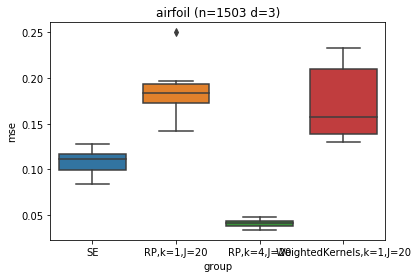

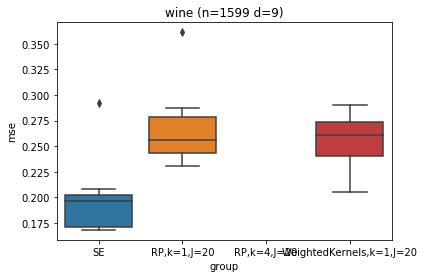

In [148]:
for dset in dsets:
    plt.figure()
    subset = df_lw[df_lw['dataset'] == dset]
    n = subset['n'].iloc[0]
    d = subset['d'].iloc[0]
    sns.boxplot(x='group', y='mse', data=subset, order=['SE', 'RP,k=1,J=20', 'RP,k=4,J=20', 'WeightedKernels,k=1,J=20'])
    plt.title('{} (n={} d={})'.format(dset, n, d))
    plt.savefig('./plots/learn_combo/{}.png'.format(dataset))
    plt.show()

# 4. Comparison with additive GPs

In [181]:
df_lw = pd.read_csv("./additive_results.csv")

In [182]:
df['additive'] = False
df_lw['J'] = 20
df_lw = pd.concat([df_lw, df])

/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [183]:
dsets = rp_experiments.get_small_datasets() + rp_experiments.get_medium_datasets()[:4]

In [184]:
df_lw['group'] = None
df_lw.loc[df_lw['RP']==False, 'group'] = 'SE'
df_lw.loc[(df_lw['RP']==True) & (df_lw['weighted_comb'] == False) & (df_lw['k']==1) & (df_lw['J'] == 20), 'group'] = 'RP,k=1,J=20'
df_lw.loc[(df_lw['RP']==True) & (df_lw['weighted_comb'] == False) & (df_lw['k']==4) & (df_lw['J'] == 20), 'group'] = 'RP,k=4,J=20'
df_lw.loc[(df_lw['additive'] == True), 'group'] = 'Additive'

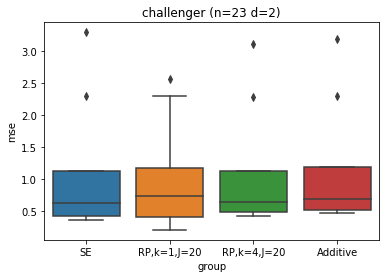

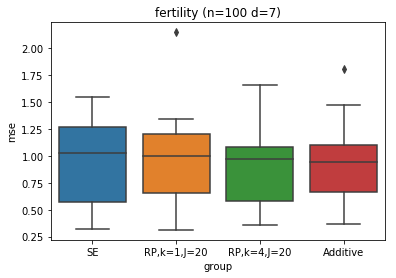

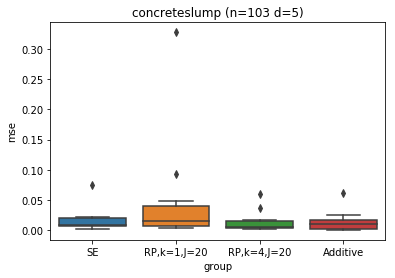

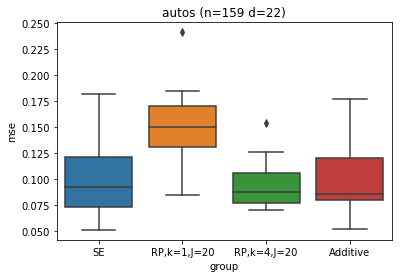

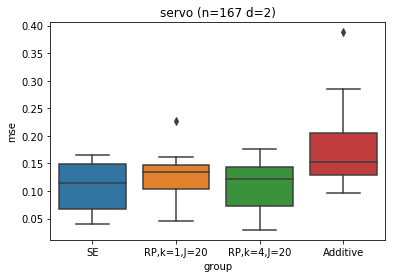

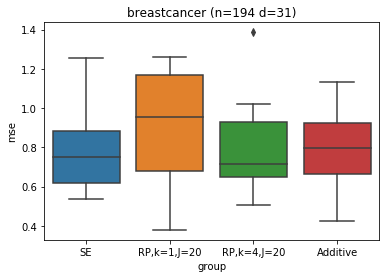

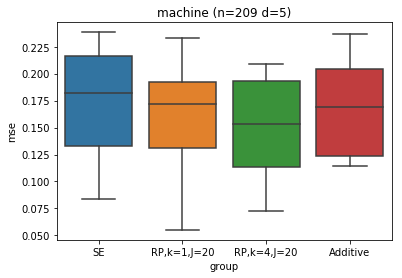

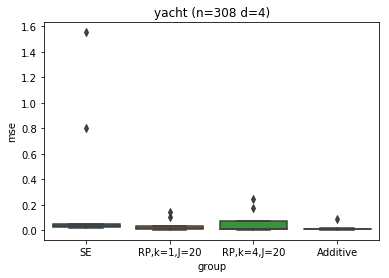

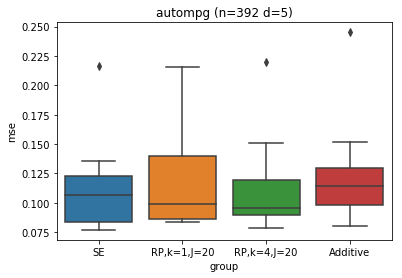

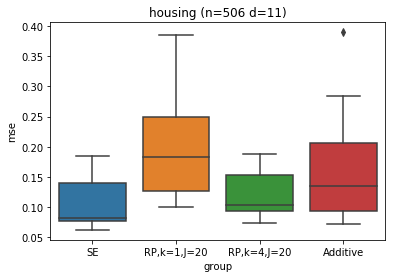

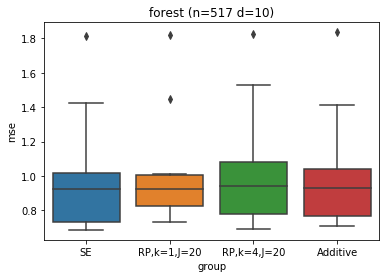

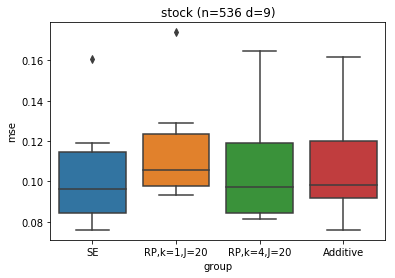

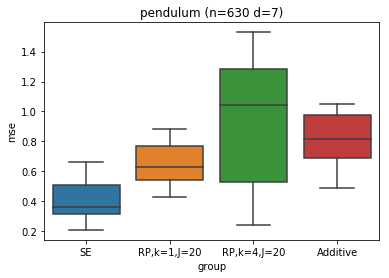

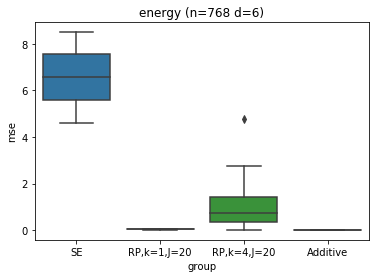

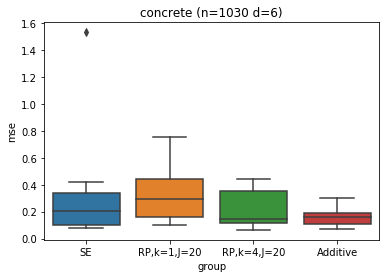

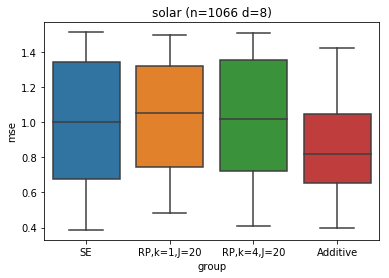

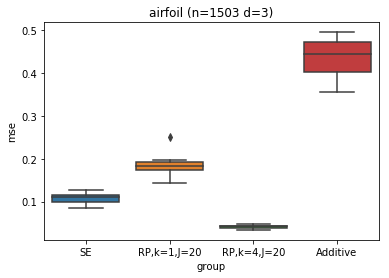

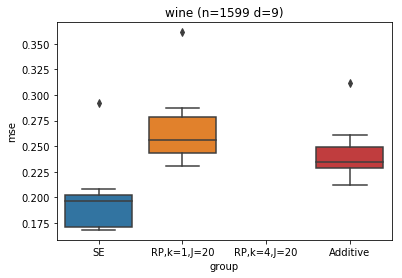

In [187]:
for dset in dsets:
    plt.figure()
    subset = df_lw[df_lw['dataset'] == dset]
    n = subset['n'].iloc[0]
    d = subset['d'].iloc[0]
    sns.boxplot(x='group', y='mse', data=subset, order=['SE', 'RP,k=1,J=20', 'RP,k=4,J=20', 'Additive'])
    plt.title('{} (n={} d={})'.format(dset, n, d))
#     plt.savefig('./plots/learn_combo/{}.png'.format(dataset))
    plt.show()

# 4. Comparison of Scalable Methods

In [149]:
df_sc = pd.read_csv('./scalable_methods_results.csv')
df_sc['group'] = None
df_sc.loc[df_sc['RP'] == False, 'group'] = 'SE+SVI'
df_sc.loc[(df_sc['RP'] == True) & (df_sc['scalable_method'] == 'ski'), 'group'] = 'RP+ski'
df_sc.loc[(df_sc['RP'] == True) & (df_sc['scalable_method'] == 'SVI'), 'group'] = 'RP+SVI'

## 4.1 Scalable Methods' MSE

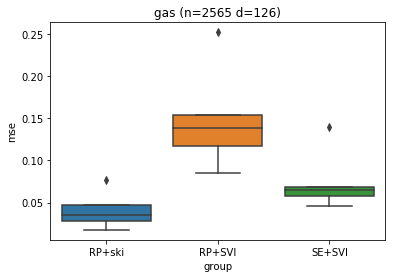

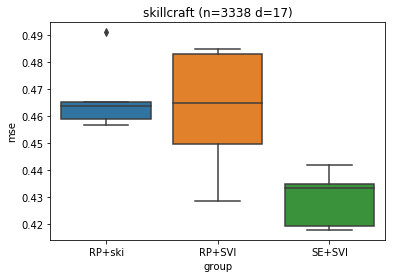

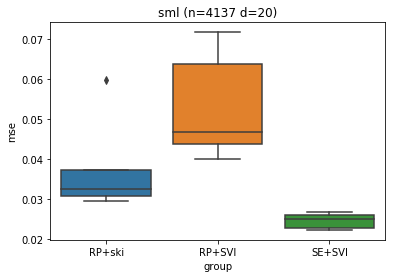

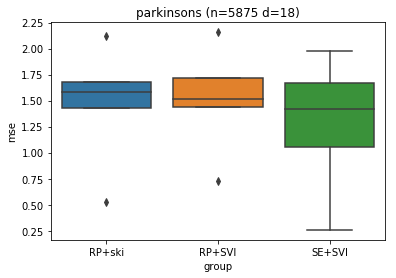

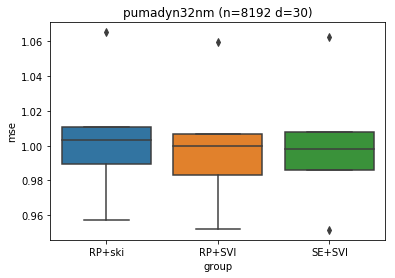

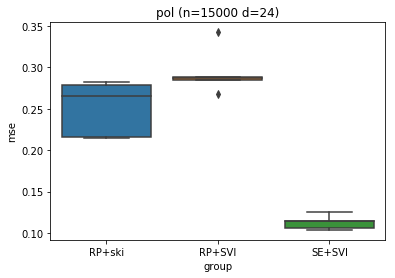

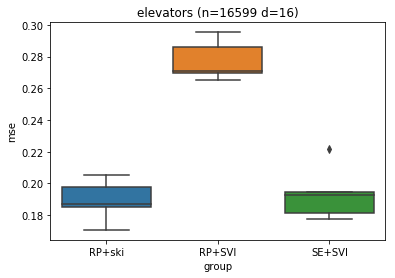

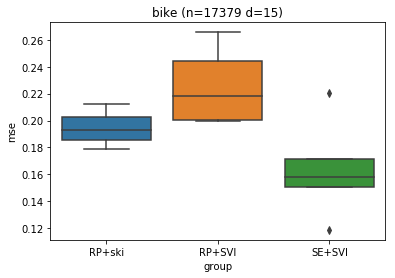

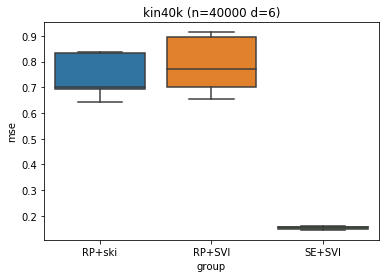

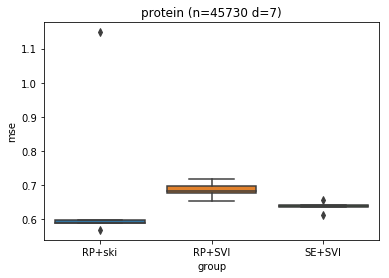

In [150]:
df_by_n = df_sc.groupby('dataset')['n'].first().sort_values()
for dset, n in df_by_n.iteritems():
    plt.figure()
    subset = df_sc[df_sc['dataset'] == dset]
    n = subset['n'].iloc[0]
    d = subset['d'].iloc[0]
    sns.boxplot(x='group', y='mse', data=subset)
    plt.title('{} (n={} d={})'.format(dset, n, d))
    plt.savefig('./plots/scalable/mse/{}.png'.format(dataset))
    plt.show()

## 4.2 Scalable Methods' Training TIme

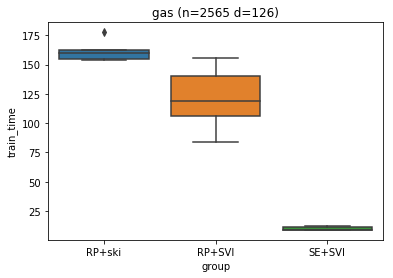

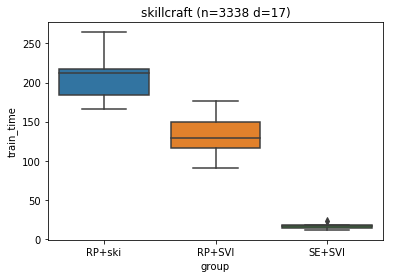

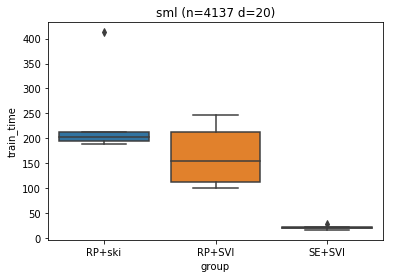

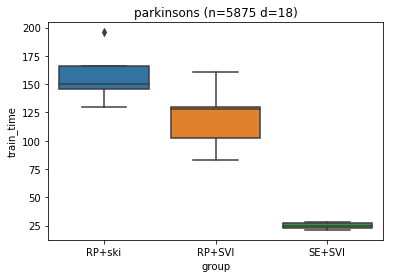

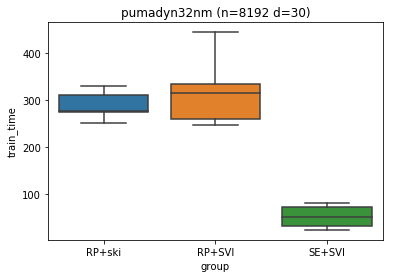

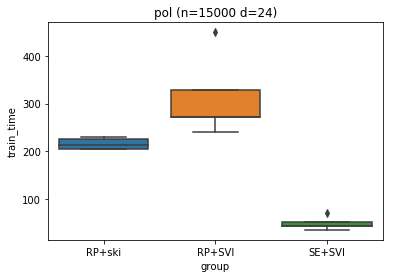

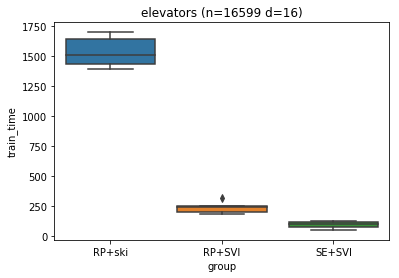

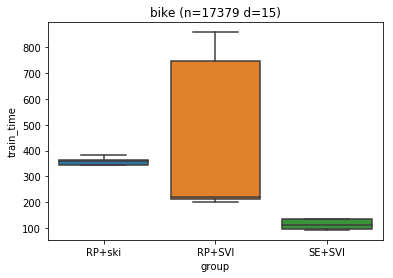

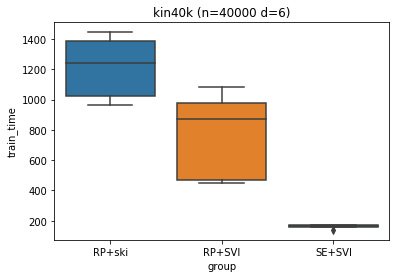

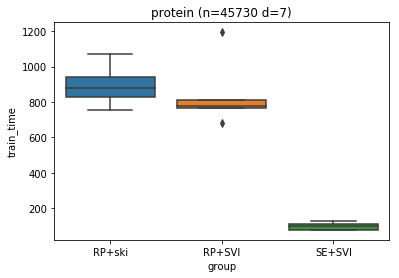

In [151]:
df_by_n = df_sc.groupby('dataset')['n'].first().sort_values()
for dset, n in df_by_n.iteritems():
    plt.figure()
    subset = df_sc[df_sc['dataset'] == dset]
    n = subset['n'].iloc[0]
    d = subset['d'].iloc[0]
    sns.boxplot(x='group', y='train_time', data=subset)
    plt.title('{} (n={} d={})'.format(dset, n, d))
    plt.savefig('./plots/scalable/train_time/{}.png'.format(dataset))
    plt.show()

## 4.3 Summary Table of Scalable Methods

In [152]:
medians = df_sc.groupby(('dataset', 'group'))['n', 'd', 'mse', 'train_time'].median().unstack()
medians['n'] = medians[('n','RP+SVI')]
medians['dn'] = medians[('n', 'RP+SVI')]
medians['dd'] = medians[('d', 'RP+SVI')]
medians = medians.drop(['n', 'd'], axis=1)
medians = medians.rename(columns={'dn': 'n', 'dd': 'd'})
medians.sort_values(['n', 'd'])

/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  """Entry point for launching an IPython kernel.


mse                      train_time               \
group          RP+SVI    RP+ski    SE+SVI      RP+SVI       RP+ski   
dataset                                                              
gas          0.138115  0.035277  0.065000  118.982450   159.934259   
skillcraft   0.464928  0.463907  0.433269  129.390844   211.711700   
sml          0.046676  0.032330  0.024931  155.295254   203.447322   
parkinsons   1.512772  1.586502  1.423384  128.453202   149.883337   
pumadyn32nm  0.999607  1.003037  0.998108  315.026321   277.510136   
pol          0.287403  0.265428  0.114508  271.249602   212.710673   
elevators    0.271181  0.187104  0.192589  240.566917  1504.840700   
bike         0.218509  0.193083  0.158120  220.606927   361.615161   
kin40k       0.769812  0.701196  0.156661  869.270860  1243.742189   
protein      0.684601  0.590921  0.639978  777.562255   880.957024   

                             n    d  
group            SE+SVI              
dataset                              
gas            9.045834   2565  126  
skillcraft    16.209251   3338   17  
sml           20.882793   4137   20  
parkinsons    24.683605   5875   18  
pumadyn32nm   52.168314   8192   30  
pol           42.754508  15000   24  
elevators     99.403323  16599   16  
bike         110.982012  17379   15  
kin40k       168.210482  40000    6  
protein       96.840300  45730    7

In [153]:
medians.to_csv('./medians_table.csv')

# Experiments directly comparable to the exact GPs with a million data points paper

In [188]:
df_sc = pd.read_csv('./comparable_.csv')
df_sc['group'] = None
df_sc.loc[df_sc['RP'] == False, 'group'] = 'SE+SVI'
df_sc.loc[(df_sc['RP'] == True) & (df_sc['scalable_method'] == 'ski'), 'group'] = 'RP+ski'
df_sc.loc[(df_sc['RP'] == True) & (df_sc['scalable_method'] == 'SVI'), 'group'] = 'RP+SVI'

In [189]:
df_sc

,Unnamed: 0,d,fold,mse,n,prior_train_nmll,repeat,state_dict_file,test_nll,train_mse,train_nll,train_time,trained_epochs,RP,k,J,dataset,scalable_method,options,group
0,0,126,0,0.029951,2565,-0.443555,0,model_state_dict_-2520936991060136728.pkl,-354.911072,0.011757,-1211.147583,626.541324,100,True,1,20,gas,ski,"{""verbose"": true, ""rp"": true, ""k"": 1, ""J"": 20,...",RP+ski
1,1,126,0,0.027426,2565,-0.476100,1,model_state_dict_7056651464425353781.pkl,20992.550781,0.013425,-1160.805786,620.537275,100,True,1,20,gas,ski,"{""verbose"": true, ""rp"": true, ""k"": 1, ""J"": 20,...",RP+ski
2,2,126,1,0.757075,2565,-0.397264,0,model_state_dict_6414093292958064104.pkl,-2453.268799,0.015001,-1050.123901,611.133688,100,True,1,20,gas,ski,"{""verbose"": true, ""rp"": true, ""k"": 1, ""J"": 20,...",RP+ski
3,3,126,1,0.092935,2565,-0.447060,1,model_state_dict_-7254933470806942653.pkl,-3911.713867,0.014842,-1089.864624,622.477382,100,True,1,20,gas,ski,"{""verbose"": true, ""rp"": true, ""k"": 1, ""J"": 20,...",RP+ski
4,4,126,2,0.030666,2565,-0.316160,0,model_state_dict_2653933931941648032.pkl,-541.617615,0.019383,-850.208130,568.191759,100,True,1,20,gas,ski,"{""verbose"": true, ""rp"": true, ""k"": 1, ""J"": 20,...",RP+ski
5,5,126,2,0.027722,2565,-0.284025,1,model_state_dict_7397221207090968104.pkl,-509.705994,0.021779,-768.309692,531.837809,100,True,1,20,gas,ski,"{""verbose"": true, ""rp"": true, ""k"": 1, ""J"": 20,...",RP+ski
6,0,126,0,0.028286,2565,-0.052499,0,model_state_dict_-1026243392941396606.pkl,-291.849548,0.019887,-728.667358,369.419794,100,False,1,20,gas,SVI,"{""verbose"": 2, ""rp"": false, ""ard"": false, ""act...",SE+SVI
7,1,126,0,0.029651,2565,-0.057466,1,model_state_dict_5407135502721811643.pkl,-267.471130,0.019717,-682.982056,364.475306,100,False,1,20,gas,SVI,"{""verbose"": 2, ""rp"": false, ""ard"": false, ""act...",SE+SVI
8,2,126,1,0.028997,2565,-0.069248,0,model_state_dict_-7316238441653972377.pkl,-289.513855,0.019389,-717.115356,348.241603,100,False,1,20,gas,SVI,"{""verbose"": 2, ""rp"": false, ""ard"": false, ""act...",SE+SVI
9,3,126,1,0.028061,2565,-0.069926,1,model_state_dict_-8955940526226463883.pkl,-316.822693,0.017092,-815.748169,377.487462,100,False,1,20,gas,SVI,"{""verbose"": 2, ""rp"": false, ""ard"": false, ""act...",SE+SVI


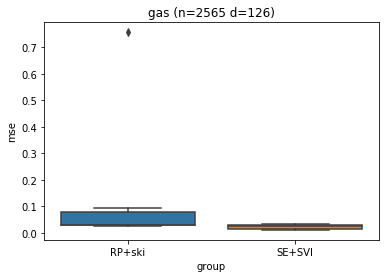

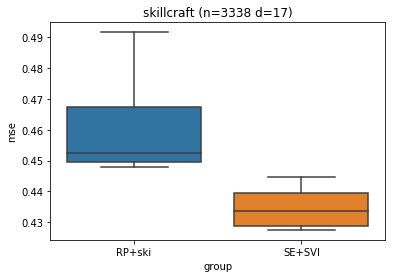

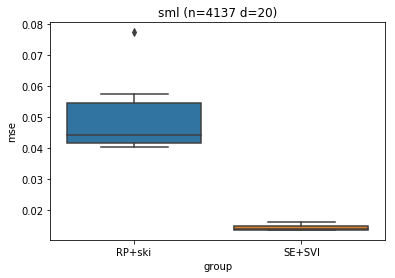

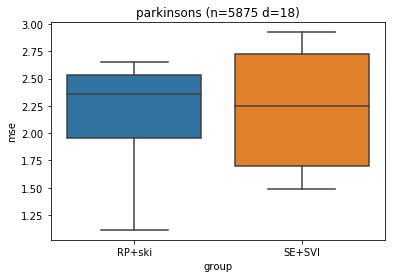

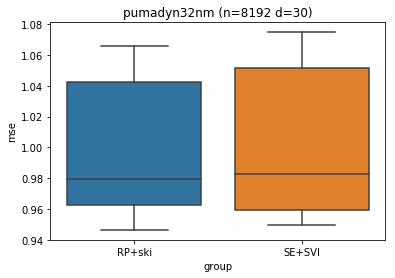

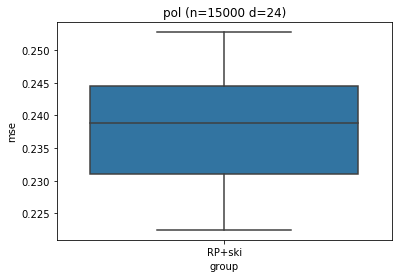

In [171]:
df_by_n = df_sc.groupby('dataset')['n'].first().sort_values()
for dset, n in df_by_n.iteritems():
    plt.figure()
    subset = df_sc[df_sc['dataset'] == dset]
    n = subset['n'].iloc[0]
    d = subset['d'].iloc[0]
    sns.boxplot(x='group', y='mse', data=subset)
    plt.title('{} (n={} d={})'.format(dset, n, d))
    plt.savefig('./plots/scalable/mse/{}.png'.format(dataset))
    plt.show()

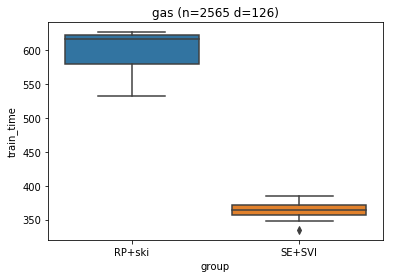

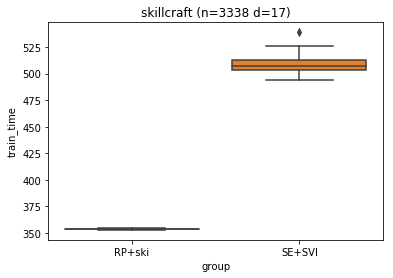

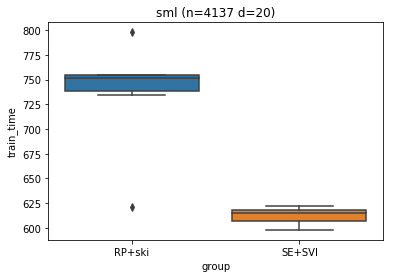

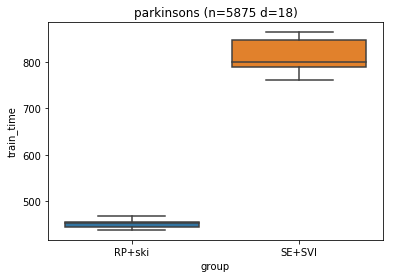

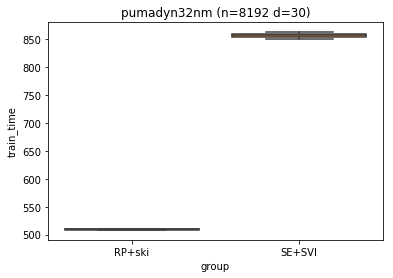

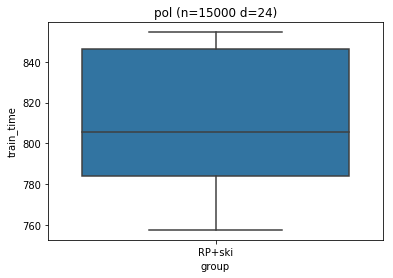

In [172]:
df_by_n = df_sc.groupby('dataset')['n'].first().sort_values()
for dset, n in df_by_n.iteritems():
    plt.figure()
    subset = df_sc[df_sc['dataset'] == dset]
    n = subset['n'].iloc[0]
    d = subset['d'].iloc[0]
    sns.boxplot(x='group', y='train_time', data=subset)
    plt.title('{} (n={} d={})'.format(dset, n, d))
#     plt.savefig('./plots/scalable/train_time/{}.png'.format(dataset))
    plt.show()